<a href="https://colab.research.google.com/github/kartickgupta/shared-task-2021/blob/main/Shared_Task_2021_RoBERTa_base_resampled_cleaned_withReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Description:
1. Model Used : RoBERTa-base
2. training Data : Cleaned 
3. Class Distribution : resampled
4. Roberta Layers = trainable

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Oct  2 21:31:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# !pip install textaugment
# import nltk
# nltk.download('all')

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from google.colab import drive
# from textaugment import Wordnet, EDA, word2vec, Translate
# from nltk import WordNetLemmatizer
# from nltk.corpus import stopwords
import gensim
import re
import matplotlib.pyplot as plt
import seaborn as sns
# !pip3 install tensorflow_text
# import tensorflow_text
# !pip install -q tf-models-official
# !pip install -q -U tensorflow-text
# from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab
# import tensorflow_hub as hub
# import tensorflow_text as tf_text
from tqdm import tqdm

In [4]:
!pip3 install transformers

     |████████████████████████████████| 2.9 MB 5.1 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
     |████████████████████████████████| 895 kB 59.8 MB/s 
     |████████████████████████████████| 636 kB 47.7 MB/s 
     |████████████████████████████████| 3.3 MB 37.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
with open('/content/drive/MyDrive/Shared Task 2021/global-headline-only.csv', 'r') as f:
    df = pd.read_csv(f)

df.head()

,data_id,event_date,year,event_type,sub_event_type,region,country,location,notes,cleaned,lemmatized,stemmed
0,8378880,09-07-2021,2021,Explosions/Remote violence,Shelling/artillery/missile attack,Middle East,Syria,Arnaba,"On 9 July 2021, regime forces shelled Arnaba t...",regime forces shelled Arnaba town in Idleb cou...,regime force shelled arnaba town idleb country...,regim forc shell arnaba town idleb countrysid ...
1,8378881,09-07-2021,2021,Explosions/Remote violence,Shelling/artillery/missile attack,Middle East,Syria,Balyun,"On 9 July 2021, regime forces shelled Balyun t...",regime forces shelled Balyun town and its vici...,regime force shelled balyun town vicinity idle...,regim forc shell balyun town vicin idleb count...
2,8381441,09-07-2021,2021,Protests,Peaceful protest,East Asia,South Korea,Jinju,"On 9 July 2021, local veterans' organizations,...",local veterans organizations including the Kor...,local veteran organization including korean wa...,local veteran organ includ korean war veteran ...
3,8383746,09-07-2021,2021,Riots,Violent demonstration,South Asia,Pakistan,Larkana,"On 9 July 2021, prisoners held a demonstration...",prisoners held a demonstration and set wood an...,prisoner held demonstration set wood clothes f...,prison held demonstr set wood cloth fire larka...
4,8381699,09-07-2021,2021,Violence against civilians,Attack,Southeast Asia,Myanmar,Hpa Yar Gyi,"On 9 July 2021, in Hpa Yar Gyi village (Thongw...",in Hpa Yar Gyi village the village administra...,hpa yar gyi village village administrator shot...,hpa yar gyi villag villag administr shot three...


In [7]:
correct_format = ['ABDUCT_DISSAP',
'AGREEMENT',
'AIR_STRIKE',
'ARMED_CLASH',
'ARREST',
'ART_MISS_ATTACK',
'ATTACK',
'CHANGE_TO_GROUP_ACT',
'CHEM_WEAP',
'DISR_WEAP',
'FORCE_AGAINST_PROTEST',
'GOV_REGAINS_TERIT',
'GRENADE',
'HQ_ESTABLISHED',
'MOB_VIOL',
'NON_STATE_ACTOR_OVERTAKES_TER',
'NON_VIOL_TERRIT_TRANSFER',
'OTHER',
'PEACE_PROTEST',
'PROPERTY_DISTRUCT',
'PROTEST_WITH_INTER',
'REM_EXPLOS',
'SEX_VIOL',
'SUIC_BOMB',
'VIOL_DEMONSTR']

In [8]:
correct_format_dict = {'Abduction/forced disappearance':'ABDUCT_DISSAP',
                       'Agreement': 'AGREEMENT',
                        'Air/drone strike' : 'AIR_STRIKE',
                         'Armed clash' : 'ARMED_CLASH',
                       'Arrests' : 'ARREST',
                       'Attack' : 'ATTACK',
                       'Change to group/activity' : 'CHANGE_TO_GROUP_ACT',
                       'Chemical weapon' : 'CHEM_WEAP',
                       'Disrupted weapons use' : 'DISR_WEAP',
                       'Excessive force against protesters' : 'FORCE_AGAINST_PROTEST',
                       'Government regains territory' : 'GOV_REGAINS_TERIT',
                       'Grenade' : 'GRENADE',
                        'Headquarters or base established' : 'HQ_ESTABLISHED',
                       'Looting/property destruction' : 'PROPERTY_DISTRUCT',
                       'Mob violence' : 'MOB_VIOL',
                       'Non-state actor overtakes territory' : 'NON_STATE_ACTOR_OVERTAKES_TER',
                       'Non-violent transfer of territory' : 'NON_VIOL_TERRIT_TRANSFER',
                       'Other' : 'OTHER',
                        'Peaceful protest' : 'PEACE_PROTEST',
                       'Protest with intervention' : 'PROTEST_WITH_INTER',
                       'Remote explosive/landmine/IED' : 'REM_EXPLOS',
                       'Sexual violence' : 'SEX_VIOL',
                       'Shelling/artillery/missile attack' : 'ART_MISS_ATTACK',
                       'Suicide bomb' : 'SUIC_BOMB',
                        'Violent demonstration' : 'VIOL_DEMONSTR'
                       }

In [9]:
correct_format_dict

{'Abduction/forced disappearance': 'ABDUCT_DISSAP',
 'Agreement': 'AGREEMENT',
 'Air/drone strike': 'AIR_STRIKE',
 'Armed clash': 'ARMED_CLASH',
 'Arrests': 'ARREST',
 'Attack': 'ATTACK',
 'Change to group/activity': 'CHANGE_TO_GROUP_ACT',
 'Chemical weapon': 'CHEM_WEAP',
 'Disrupted weapons use': 'DISR_WEAP',
 'Excessive force against protesters': 'FORCE_AGAINST_PROTEST',
 'Government regains territory': 'GOV_REGAINS_TERIT',
 'Grenade': 'GRENADE',
 'Headquarters or base established': 'HQ_ESTABLISHED',
 'Looting/property destruction': 'PROPERTY_DISTRUCT',
 'Mob violence': 'MOB_VIOL',
 'Non-state actor overtakes territory': 'NON_STATE_ACTOR_OVERTAKES_TER',
 'Non-violent transfer of territory': 'NON_VIOL_TERRIT_TRANSFER',
 'Other': 'OTHER',
 'Peaceful protest': 'PEACE_PROTEST',
 'Protest with intervention': 'PROTEST_WITH_INTER',
 'Remote explosive/landmine/IED': 'REM_EXPLOS',
 'Sexual violence': 'SEX_VIOL',
 'Shelling/artillery/missile attack': 'ART_MISS_ATTACK',
 'Suicide bomb': 'SUIC_B

In [10]:
def correct_format(text):
    correct_label = correct_format_dict[text]
    return correct_label

df['sub_event_type'] = df['sub_event_type'].apply(correct_format)

In [11]:
df.sub_event_type.value_counts()

PEACE_PROTEST                    329399
ARMED_CLASH                      239828
ATTACK                           132202
ART_MISS_ATTACK                   64743
MOB_VIOL                          42079
VIOL_DEMONSTR                     41003
AIR_STRIKE                        34020
PROTEST_WITH_INTER                31784
REM_EXPLOS                        30620
PROPERTY_DISTRUCT                 24315
ABDUCT_DISSAP                     14624
ARREST                             8668
CHANGE_TO_GROUP_ACT                7925
DISR_WEAP                          7499
GOV_REGAINS_TERIT                  6148
OTHER                              5353
FORCE_AGAINST_PROTEST              3098
GRENADE                            2948
NON_STATE_ACTOR_OVERTAKES_TER      2670
SEX_VIOL                           2196
AGREEMENT                          1460
NON_VIOL_TERRIT_TRANSFER            989
SUIC_BOMB                           635
HQ_ESTABLISHED                      311
CHEM_WEAP                            10


In [12]:
df.drop_duplicates(['lemmatized']).sub_event_type.value_counts()

PEACE_PROTEST                    305383
ARMED_CLASH                       96231
ATTACK                            65363
ART_MISS_ATTACK                   33279
VIOL_DEMONSTR                     24574
MOB_VIOL                          21098
AIR_STRIKE                        18620
REM_EXPLOS                        16110
PROTEST_WITH_INTER                15003
PROPERTY_DISTRUCT                 12036
ABDUCT_DISSAP                      7214
CHANGE_TO_GROUP_ACT                7098
ARREST                             4238
DISR_WEAP                          3866
OTHER                              3698
GOV_REGAINS_TERIT                  2424
GRENADE                            1530
FORCE_AGAINST_PROTEST              1520
NON_STATE_ACTOR_OVERTAKES_TER      1198
SEX_VIOL                           1027
AGREEMENT                           692
NON_VIOL_TERRIT_TRANSFER            512
SUIC_BOMB                           319
HQ_ESTABLISHED                      291
CHEM_WEAP                             4


In [13]:
event_types_dict = {}
for num, name in enumerate(list(df['sub_event_type'].unique())):
    event_types_dict[name] = num
    # print(name, " : ", num)

event_types_dict

event_types_dict_inverse = {k:v for v,k in event_types_dict.items()}
print(event_types_dict)
print( event_types_dict_inverse)

{'ART_MISS_ATTACK': 0, 'PEACE_PROTEST': 1, 'VIOL_DEMONSTR': 2, 'ATTACK': 3, 'AIR_STRIKE': 4, 'ARMED_CLASH': 5, 'MOB_VIOL': 6, 'PROTEST_WITH_INTER': 7, 'FORCE_AGAINST_PROTEST': 8, 'PROPERTY_DISTRUCT': 9, 'OTHER': 10, 'REM_EXPLOS': 11, 'GOV_REGAINS_TERIT': 12, 'ABDUCT_DISSAP': 13, 'CHANGE_TO_GROUP_ACT': 14, 'NON_STATE_ACTOR_OVERTAKES_TER': 15, 'ARREST': 16, 'SEX_VIOL': 17, 'DISR_WEAP': 18, 'NON_VIOL_TERRIT_TRANSFER': 19, 'GRENADE': 20, 'HQ_ESTABLISHED': 21, 'SUIC_BOMB': 22, 'AGREEMENT': 23, 'CHEM_WEAP': 24}
{0: 'ART_MISS_ATTACK', 1: 'PEACE_PROTEST', 2: 'VIOL_DEMONSTR', 3: 'ATTACK', 4: 'AIR_STRIKE', 5: 'ARMED_CLASH', 6: 'MOB_VIOL', 7: 'PROTEST_WITH_INTER', 8: 'FORCE_AGAINST_PROTEST', 9: 'PROPERTY_DISTRUCT', 10: 'OTHER', 11: 'REM_EXPLOS', 12: 'GOV_REGAINS_TERIT', 13: 'ABDUCT_DISSAP', 14: 'CHANGE_TO_GROUP_ACT', 15: 'NON_STATE_ACTOR_OVERTAKES_TER', 16: 'ARREST', 17: 'SEX_VIOL', 18: 'DISR_WEAP', 19: 'NON_VIOL_TERRIT_TRANSFER', 20: 'GRENADE', 21: 'HQ_ESTABLISHED', 22: 'SUIC_BOMB', 23: 'AGREEME

In [14]:
dict_list = list(event_types_dict.keys())

In [15]:
def text_to_numerical_category(name):
    num = event_types_dict[name]
    return num

# print(text_to_numerical_category('Peaceful protest'))
df['labels'] = df['sub_event_type'].apply(text_to_numerical_category)

In [16]:
df.drop(columns=['data_id', 'event_date', 'year','event_type','region','country', 'location',	'notes','lemmatized', 'stemmed'	], inplace=True)

In [17]:
df.head()

,sub_event_type,cleaned,labels
0,ART_MISS_ATTACK,regime forces shelled Arnaba town in Idleb cou...,0
1,ART_MISS_ATTACK,regime forces shelled Balyun town and its vici...,0
2,PEACE_PROTEST,local veterans organizations including the Kor...,1
3,VIOL_DEMONSTR,prisoners held a demonstration and set wood an...,2
4,ATTACK,in Hpa Yar Gyi village the village administra...,3


## Handling Imbalanced Dataset

In [18]:
from sklearn.utils import shuffle

lemm = []
labels = []
THRESH_1 = 20000
THRESH_2 = 10000
THRESH_3 = 1000

for group in df.sub_event_type.unique():
    # Having More Than 20K
    if len(df.groupby('sub_event_type').get_group(group).cleaned.unique()) > THRESH_1:
        lemm += (list(shuffle(df.groupby('sub_event_type').get_group(group).cleaned.unique()))[:THRESH_1])
        labels += ([group]*THRESH_1)
     # Having Unique b/w 20K and 10K - Take top 20K from all
    elif len(df.groupby('sub_event_type').get_group(group).cleaned.unique()) < THRESH_1 and len(df.groupby('sub_event_type').get_group(group).cleaned.unique()) > THRESH_2:
       lemm += (list(shuffle(df.groupby('sub_event_type').get_group(group).cleaned))[:THRESH_1])
       labels += ([group]*THRESH_1)
    # Having b/w 20K and 5K - take all
    elif len(df.groupby('sub_event_type').get_group(group).cleaned) < 20000 and len(df.groupby('sub_event_type').get_group(group).cleaned) > 5000:
       lemm += list(shuffle(df.groupby('sub_event_type').get_group(group).cleaned))
       labels += ([group]*len(list(shuffle(df.groupby('sub_event_type').get_group(group).cleaned))))
     # Having Less Than 1K - Multipy by 6
    elif len(df.groupby('sub_event_type').get_group(group).cleaned) < THRESH_3:
        for i in range(6):
            lemm += list(shuffle(df.groupby('sub_event_type').get_group(group).cleaned))
            labels += ([group]*len(list(shuffle(df.groupby('sub_event_type').get_group(group).cleaned))))
    # Remaining - Multiply by 2
    else:
         for i in range(2):
            lemm += list(shuffle(df.groupby('sub_event_type').get_group(group).cleaned))
            labels += ([group]*len(list(shuffle(df.groupby('sub_event_type').get_group(group).cleaned))))


In [19]:
len(lemm)

286631

In [20]:
len(labels)

286631

In [21]:
balanced_df = pd.DataFrame({'Text' : lemm, 'Labels': labels})

In [22]:
balanced_df.head()

,Text,Labels
0,regime forces shelled Khalsa in Aleppo with ar...,ART_MISS_ATTACK
1,incendiary devices launched from Gaza sparked ...,ART_MISS_ATTACK
2,an incendiary balloon launched from the Gaza S...,ART_MISS_ATTACK
3,Taliban militants attacked with heavy weapons ...,ART_MISS_ATTACK
4,the NAF rebel forces fired grenade launchers a...,ART_MISS_ATTACK


In [23]:
event_types_dict_new = {}
for num, name in enumerate(list(balanced_df.Labels.unique())):
    event_types_dict_new[name] = num
    # print(name, " : ", num)

event_types_dict_new

event_types_dict_inverse_new = {k:v for v,k in event_types_dict_new.items()}
print(event_types_dict_new)
print( event_types_dict_inverse_new)

{'ART_MISS_ATTACK': 0, 'PEACE_PROTEST': 1, 'VIOL_DEMONSTR': 2, 'ATTACK': 3, 'AIR_STRIKE': 4, 'ARMED_CLASH': 5, 'MOB_VIOL': 6, 'PROTEST_WITH_INTER': 7, 'FORCE_AGAINST_PROTEST': 8, 'PROPERTY_DISTRUCT': 9, 'OTHER': 10, 'REM_EXPLOS': 11, 'GOV_REGAINS_TERIT': 12, 'ABDUCT_DISSAP': 13, 'CHANGE_TO_GROUP_ACT': 14, 'NON_STATE_ACTOR_OVERTAKES_TER': 15, 'ARREST': 16, 'SEX_VIOL': 17, 'DISR_WEAP': 18, 'NON_VIOL_TERRIT_TRANSFER': 19, 'GRENADE': 20, 'HQ_ESTABLISHED': 21, 'SUIC_BOMB': 22, 'AGREEMENT': 23, 'CHEM_WEAP': 24}
{0: 'ART_MISS_ATTACK', 1: 'PEACE_PROTEST', 2: 'VIOL_DEMONSTR', 3: 'ATTACK', 4: 'AIR_STRIKE', 5: 'ARMED_CLASH', 6: 'MOB_VIOL', 7: 'PROTEST_WITH_INTER', 8: 'FORCE_AGAINST_PROTEST', 9: 'PROPERTY_DISTRUCT', 10: 'OTHER', 11: 'REM_EXPLOS', 12: 'GOV_REGAINS_TERIT', 13: 'ABDUCT_DISSAP', 14: 'CHANGE_TO_GROUP_ACT', 15: 'NON_STATE_ACTOR_OVERTAKES_TER', 16: 'ARREST', 17: 'SEX_VIOL', 18: 'DISR_WEAP', 19: 'NON_VIOL_TERRIT_TRANSFER', 20: 'GRENADE', 21: 'HQ_ESTABLISHED', 22: 'SUIC_BOMB', 23: 'AGREEME

## Event Frequency comparison w/ Original and Augmented Data.

In [24]:
df.sub_event_type.value_counts()

PEACE_PROTEST                    329399
ARMED_CLASH                      239828
ATTACK                           132202
ART_MISS_ATTACK                   64743
MOB_VIOL                          42079
VIOL_DEMONSTR                     41003
AIR_STRIKE                        34020
PROTEST_WITH_INTER                31784
REM_EXPLOS                        30620
PROPERTY_DISTRUCT                 24315
ABDUCT_DISSAP                     14624
ARREST                             8668
CHANGE_TO_GROUP_ACT                7925
DISR_WEAP                          7499
GOV_REGAINS_TERIT                  6148
OTHER                              5353
FORCE_AGAINST_PROTEST              3098
GRENADE                            2948
NON_STATE_ACTOR_OVERTAKES_TER      2670
SEX_VIOL                           2196
AGREEMENT                          1460
NON_VIOL_TERRIT_TRANSFER            989
SUIC_BOMB                           635
HQ_ESTABLISHED                      311
CHEM_WEAP                            10


In [25]:
balanced_df.Labels.value_counts()

AIR_STRIKE                       20000
ARMED_CLASH                      20000
PROTEST_WITH_INTER               20000
PEACE_PROTEST                    20000
ART_MISS_ATTACK                  20000
ATTACK                           20000
VIOL_DEMONSTR                    20000
PROPERTY_DISTRUCT                20000
MOB_VIOL                         20000
REM_EXPLOS                       20000
ABDUCT_DISSAP                    14624
ARREST                            8668
CHANGE_TO_GROUP_ACT               7925
DISR_WEAP                         7499
FORCE_AGAINST_PROTEST             6196
GOV_REGAINS_TERIT                 6148
NON_VIOL_TERRIT_TRANSFER          5934
GRENADE                           5896
OTHER                             5353
NON_STATE_ACTOR_OVERTAKES_TER     5340
SEX_VIOL                          4392
SUIC_BOMB                         3810
AGREEMENT                         2920
HQ_ESTABLISHED                    1866
CHEM_WEAP                           60
Name: Labels, dtype: int6

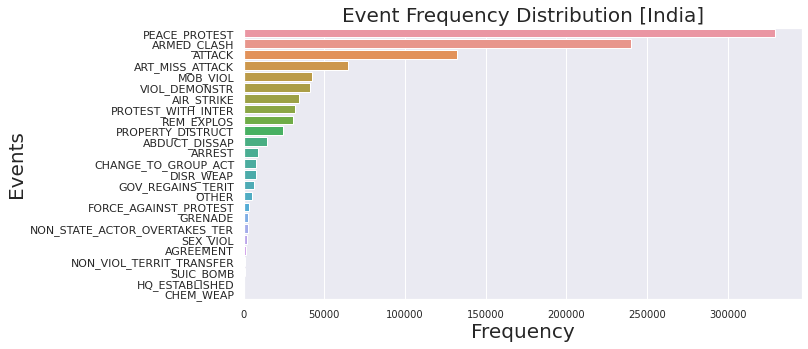

In [26]:
sns.set_theme(style="darkgrid")
x = df['sub_event_type'].value_counts()
y = x.index
plt.figure(figsize=(10, 5))
g = sns.barplot(x=x, y=y)
plt.title("Event Frequency Distribution [India]", fontsize=20)
plt.ylabel('Events', fontsize= 20)
plt.yticks(fontsize=11)
plt.xlabel('Frequency', fontsize=20)
plt.xticks(fontsize=10)
plt.show()

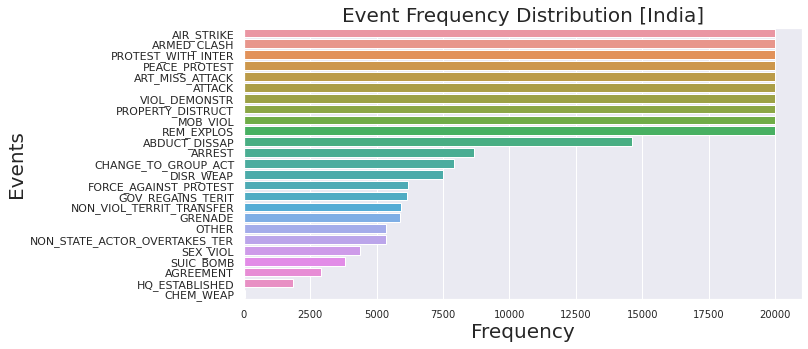

In [27]:
sns.set_theme(style="darkgrid")
x = balanced_df.Labels.value_counts()
y = x.index
plt.figure(figsize=(10, 5))
g = sns.barplot(x=x, y=y)
plt.title("Event Frequency Distribution [India]", fontsize=20)
plt.ylabel('Events', fontsize= 20)
plt.yticks(fontsize=11)
plt.xlabel('Frequency', fontsize=20)
plt.xticks(fontsize=10)
plt.show()

In [28]:
balanced_df['NumLabel'] = balanced_df.Labels.apply(text_to_numerical_category)

In [29]:
balanced_df.head()

,Text,Labels,NumLabel
0,regime forces shelled Khalsa in Aleppo with ar...,ART_MISS_ATTACK,0
1,incendiary devices launched from Gaza sparked ...,ART_MISS_ATTACK,0
2,an incendiary balloon launched from the Gaza S...,ART_MISS_ATTACK,0
3,Taliban militants attacked with heavy weapons ...,ART_MISS_ATTACK,0
4,the NAF rebel forces fired grenade launchers a...,ART_MISS_ATTACK,0


# RoBERTa

In [30]:
max_classes = len(balanced_df.Labels.unique())
max_length = 128

In [31]:
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification

# Same as before
checkpoint = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(checkpoint, max_length=max_length)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

## Hyperparametrs

In [32]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay

EPOCHS = 2
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
batch_size = 64

# num_train_steps =  len((balanced_df.NumLabel) // batch_size) * EPOCHS
# lr_scheduler = PolynomialDecay(initial_learning_rate=5e-5,
#                                end_learning_rate=0.,
#                                decay_steps=num_train_steps
#                                )

from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=5e-5)

## Tokenization

In [33]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
result_df = shuffle(balanced_df)

In [34]:
result_df

,Text,Labels,NumLabel
215189,ProHadi forces and affiliates claimed to have ...,GOV_REGAINS_TERIT,12
194123,April AMISOM forces were targeted with an IED ...,REM_EXPLOS,11
15882,regime forces shelled Kafr Oweid town in Idleb...,ART_MISS_ATTACK,0
138953,September a Kashmiri student was assaulted by ...,MOB_VIOL,6
9409,opposition rebels shelled regime forces positi...,ART_MISS_ATTACK,0
...,...,...,...
19744,rebel and Islamist factions shelled regime pos...,ART_MISS_ATTACK,0
142071,members of the Islamic Movement of Nigeria sta...,PROTEST_WITH_INTER,7
226897,Islah forces reportedly stormed the house of J...,ABDUCT_DISSAP,13
102264,the Algerian Army killed three members of an u...,ARMED_CLASH,5


In [35]:
# result_df.to_csv('resampled-training-data.csv', index=True)

In [36]:
# result_df = pd.read_csv('/content/drive/MyDrive/Shared-Task-2021/resampled-training-data-ggod.csv', index_col=0)
# result_df

### Train-Test-Split

In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(result_df.Text, result_df.NumLabel, test_size = 0.1, random_state = 42, stratify =result_df.NumLabel)

### Label Encoding

In [38]:
max_classes = len(balanced_df.Labels.unique())
print(max_classes)

25


In [39]:
%%time
encoded_labels_train = to_categorical(Y_train, num_classes=max_classes)
encoded_labels_test = to_categorical(Y_test, num_classes=max_classes)

CPU times: user 13.6 ms, sys: 0 ns, total: 13.6 ms
Wall time: 12.3 ms


### Input-Tokenization

#### Defining RoBERTa Tokenizer

In [40]:
def roberta_encode(data,maximum_length) :
  input_ids = []
  attention_masks = []
  

  for i in tqdm(range(len(data))):
      encoded = tokenizer.encode_plus(
        
        data[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        
        return_attention_mask=True,
        
      )
      
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids),np.array(attention_masks)

#### Train Data

In [41]:
%%time
train_inputs,train_attention_masks = roberta_encode(list(X_train), max_length)

  0%|          | 0/257967 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 257967/257967 [02:08<00:00, 2011.90it/s]


CPU times: user 2min 10s, sys: 3.51 s, total: 2min 14s
Wall time: 2min 13s


#### Validation Data

In [42]:
test_inputs,test_attention_masks = roberta_encode(list(X_test), max_length)

  0%|          | 0/28664 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 28664/28664 [00:13<00:00, 2174.73it/s]


In [43]:
print(f'Number of Samples in Training Set : {len(X_train)} Number of Samples in Validation Set: {len(X_test)} ')

Number of Samples in Training Set : 257967 Number of Samples in Validation Set: 28664 


In [44]:
# test_inputs = tokenizer(list(X_test), padding=True, truncation=True, return_tensors="np")

# test_inputs["labels"] = tf.reshape(tf.constant(encoded_labels_test), (len(list(X_test)), max_classes)) 

### Tensorflow-Input-Pipeline

In [45]:
train_dataset = tf.data.Dataset.from_tensor_slices(((train_inputs,train_attention_masks), encoded_labels_train)).shuffle(70000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices(((test_inputs,test_attention_masks), encoded_labels_test)).shuffle(70000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

## Custom Callbacks

In [46]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
!mkdir checkpoints
filepath = "saved-model-{epoch:02d}.h5"
MyCheckpoint = ModelCheckpoint(filepath,
                               monitor = 'val_categorical_accuracy',
                               verbose = 1,
                               save_best_only = True,
                               mode='auto',
                               save_weights_only = True)

MyEarlyStopping = EarlyStopping(patience =1,
                                monitor='val_categorical_accuracy',
                                restore_best_weights = True,
                                verbose = 1)

ModelSaver = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

## Class Weight Balancing

In [47]:
from sklearn.utils import class_weight
class_weights_array = class_weight.compute_class_weight('balanced'
                                               ,np.unique(balanced_df.NumLabel)
                                               ,balanced_df.NumLabel)

class_weights_array

array([  0.573262  ,   0.573262  ,   0.573262  ,   0.573262  ,
         0.573262  ,   0.573262  ,   0.573262  ,   0.573262  ,
         1.85042608,   0.573262  ,   2.14183449,   0.573262  ,
         1.86487313,   0.78400164,   1.44671798,   2.14704869,
         1.32270881,   2.6104827 ,   1.52890252,   1.93212673,
         1.94457938,   6.14428725,   3.00924934,   3.92645205,
       191.08733333])

In [48]:
class_weights = {i : class_weights_array[i] for i in range(len(class_weights_array))}
class_weights

{0: 0.573262,
 1: 0.573262,
 2: 0.573262,
 3: 0.573262,
 4: 0.573262,
 5: 0.573262,
 6: 0.573262,
 7: 0.573262,
 8: 1.8504260813428017,
 9: 0.573262,
 10: 2.141834485335326,
 11: 0.573262,
 12: 1.8648731294729994,
 13: 0.7840016411378555,
 14: 1.4467179810725552,
 15: 2.1470486891385767,
 16: 1.322708814028611,
 17: 2.6104826958105645,
 18: 1.528902520336045,
 19: 1.9321267273340075,
 20: 1.9445793758480325,
 21: 6.144287245444802,
 22: 3.009249343832021,
 23: 3.9264520547945208,
 24: 191.08733333333333}

## Building Model

### Defining Model Metrics

In [49]:
# !pip install tensorflow_addons
# import tensorflow_addons as tfa

# macro_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='macro')
# micro_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='micro')
# weighted_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='weighted')
precision = tf.metrics.Precision()
recall = tf.metrics.Recall()
categorical_accuracry = tf.metrics.CategoricalAccuracy()

class F1_metric(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        # Initialize our metric by initializing the two metrics it's based on:
        # Precision and Recall
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Update our metric by updating the two metrics it's based on
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

    def result(self):
        # To get the F1 result, we compute the harmonic mean of the current
        # precision and recall
        return 2 / ((1 / self.precision.result()) + (1 / self.recall.result())) 

F1Score = F1_metric()
metrics = [categorical_accuracry, F1Score]


### Custom Model Creation

In [50]:
def create_model(roberta_model):
  input_ids = tf.keras.Input(shape=(max_length,),dtype='int32')
  attention_masks = tf.keras.Input(shape=(max_length,),dtype='int32')
  
  output = roberta_model([input_ids,attention_masks])
  output = output[1]
  
#   output = tf.keras.layers.Dense(128,activation='relu',)(output)
#   output = tf.keras.layers.Dropout(0.2)(output)
#   output = tf.keras.layers.BatchNormalization()(output)

#   output = tf.keras.layers.Dense(64,activation='relu',)(output)
#   output = tf.keras.layers.Dropout(0.2)(output)
  output = tf.keras.layers.BatchNormalization()(output)
  output = tf.keras.layers.Dense(32,activation='relu', kernel_regularizer='l2')(output)
  output = tf.keras.layers.Dropout(0.2)(output)
#   output = tf.keras.layers.BatchNormalization()(output)

  output = tf.keras.layers.Dense(units=max_classes,activation='softmax')(output)
  model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
  model.compile(optimizer= opt,
              loss= loss,
              metrics = metrics)
  return model

## Model Summary

In [51]:
from transformers import TFRobertaModel
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

model = create_model(roberta_model)
# model.layers[2].trainable = False
model.summary()

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 124645632   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 768)          3072        tf_roberta_model[0][1]       

## Model Training

In [53]:
%%time
history = model.fit([train_inputs,train_attention_masks], encoded_labels_train, 
                    validation_data=([test_inputs, test_attention_masks], encoded_labels_test),
                    epochs = EPOCHS,
                    batch_size = 64,
                    verbose = 1,
                    class_weight=class_weights,
                    callbacks = [MyCheckpoint, MyEarlyStopping]
                    )

Epoch 1/2
4031/4031 [==============================] - 3730s 921ms/step - loss: 1.2127 - categorical_accuracy: 0.8141 - f1_score: 0.8185 - val_loss: 0.7255 - val_categorical_accuracy: 0.9313 - val_f1_score: 0.9319

Epoch 00001: val_categorical_accuracy improved from -inf to 0.93134, saving model to saved-model-01.h5
Epoch 2/2
4031/4031 [==============================] - 3713s 921ms/step - loss: 0.5883 - categorical_accuracy: 0.9272 - f1_score: 0.9250 - val_loss: 0.4564 - val_categorical_accuracy: 0.9403 - val_f1_score: 0.9407

Epoch 00002: val_categorical_accuracy improved from 0.93134 to 0.94027, saving model to saved-model-02.h5
CPU times: user 1h 17min 6s, sys: 12min 3s, total: 1h 29min 9s
Wall time: 2h 4min 6s


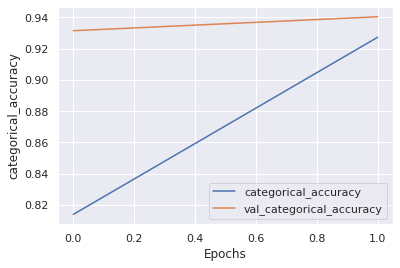

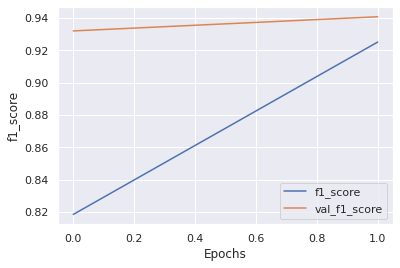

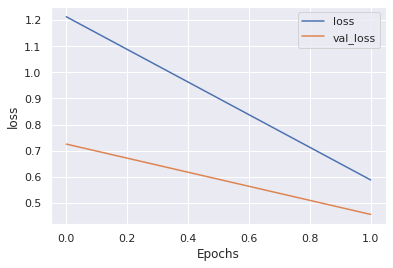

In [54]:
import matplotlib.pyplot as plt 
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "categorical_accuracy")
plot_graphs(history, "f1_score")
plot_graphs(history, 'loss')


In [ ]:
# model.save('BERT-Model.h5')

# Epoch - 2

In [55]:
test_file = pd.read_csv('/content/drive/MyDrive/Shared Task 2021/test-set-with-labels-cleaned.txt', index_col=0)

In [56]:
test_file.head()

,EventSnippet,SubType,processed,lemmatized
id,,,,
1,The US warplanes pounded the village of Kashka...,AIR_STRIKE,the us warplanes pounded the village of kashka...,u warplane pounded village kashkash southern p...
3,Officers brutally attacked and injured a peace...,FORCE_AGAINST_PROTEST,officers brutally attacked and injured a peace...,officer brutally attacked injured peaceful stu...
4,"On December 13, ISIS fighters recaptured the v...",NON_STATE_ACTOR_OVERTAKES_TER,isis fighters recaptured the village of kashma...,isi fighter recaptured village kashma syrian a...
5,Vice-President Mike Pence said Thursday that t...,AGREEMENT,vice-president mike pence said thursday that t...,vice-president mike penny said thursday mainly...
6,A helicopter on Thursday is said to have dropp...,CHEM_WEAP,a helicopter thursday is said to have dropped ...,helicopter thursday said dropped container tox...


## For Cleaned Text

In [57]:
final_test_inputs, final_test_attention_masks = roberta_encode(list(test_file.processed), max_length)

  0%|          | 0/829 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 829/829 [00:00<00:00, 1534.99it/s]


In [58]:
y_preds = np.argmax(model.predict([final_test_inputs, final_test_attention_masks]), axis=1)

In [59]:
y_preds

array([ 4,  8, 12, 23, 10, 10,  1, 19, 19, 18, 21, 10,  1, 14, 20,  2, 18,
        8,  6,  3,  5,  0, 20,  3, 14,  6,  2, 18,  6, 18,  5,  0, 20, 14,
       23, 20, 14, 22, 23, 16, 11, 18, 22, 18, 18,  5, 19,  8, 17, 10, 16,
       10, 15, 11, 19, 16, 19, 17,  0, 18, 16, 10, 13,  5,  6,  2,  5, 18,
        6, 17,  7,  1,  4, 20, 17, 19, 15,  1,  2, 21, 20, 20,  1,  3, 14,
        2,  2,  1, 10, 18,  3, 13, 18,  4,  2, 18,  2,  1,  1, 15,  8, 20,
       23,  0, 10, 18,  1,  3,  7,  2, 16,  0, 19, 12, 12,  4, 20, 13,  8,
       23,  6,  6, 10,  8,  6, 14, 13, 14,  1, 18, 14,  0, 13, 14, 10,  5,
        0, 16, 11, 14,  1,  6,  6,  0,  4,  0,  9,  1, 11, 23,  5, 13, 23,
       23, 16, 14, 21, 13, 16, 16, 18, 14,  3, 18,  3,  0, 11, 10,  4, 18,
       11, 18,  5, 19, 21,  1,  1, 16, 23, 11, 18, 14, 11, 16,  1, 20, 22,
        9, 16, 20, 10, 10, 22, 19,  2, 22,  8, 20, 14,  3, 18, 22, 22, 11,
        8, 11, 17,  4, 15, 20, 10,  2,  1, 12, 15, 16,  7, 16, 17,  3,  1,
        1,  1,  6,  6,  5

In [60]:
test_file['pred-labels-cleaned'] = y_preds

In [61]:
test_file.head()

,EventSnippet,SubType,processed,lemmatized,pred-labels-cleaned
id,,,,,
1,The US warplanes pounded the village of Kashka...,AIR_STRIKE,the us warplanes pounded the village of kashka...,u warplane pounded village kashkash southern p...,4
3,Officers brutally attacked and injured a peace...,FORCE_AGAINST_PROTEST,officers brutally attacked and injured a peace...,officer brutally attacked injured peaceful stu...,8
4,"On December 13, ISIS fighters recaptured the v...",NON_STATE_ACTOR_OVERTAKES_TER,isis fighters recaptured the village of kashma...,isi fighter recaptured village kashma syrian a...,12
5,Vice-President Mike Pence said Thursday that t...,AGREEMENT,vice-president mike pence said thursday that t...,vice-president mike penny said thursday mainly...,23
6,A helicopter on Thursday is said to have dropp...,CHEM_WEAP,a helicopter thursday is said to have dropped ...,helicopter thursday said dropped container tox...,10


In [62]:
def num_to_text_labels(num):
    text = event_types_dict_inverse[num]
    return text

test_file['text-labels-cleaned'] = test_file['pred-labels-cleaned'].apply(num_to_text_labels)

In [63]:
test_file.head()

,EventSnippet,SubType,processed,lemmatized,pred-labels-cleaned,text-labels-cleaned
id,,,,,,
1,The US warplanes pounded the village of Kashka...,AIR_STRIKE,the us warplanes pounded the village of kashka...,u warplane pounded village kashkash southern p...,4,AIR_STRIKE
3,Officers brutally attacked and injured a peace...,FORCE_AGAINST_PROTEST,officers brutally attacked and injured a peace...,officer brutally attacked injured peaceful stu...,8,FORCE_AGAINST_PROTEST
4,"On December 13, ISIS fighters recaptured the v...",NON_STATE_ACTOR_OVERTAKES_TER,isis fighters recaptured the village of kashma...,isi fighter recaptured village kashma syrian a...,12,GOV_REGAINS_TERIT
5,Vice-President Mike Pence said Thursday that t...,AGREEMENT,vice-president mike pence said thursday that t...,vice-president mike penny said thursday mainly...,23,AGREEMENT
6,A helicopter on Thursday is said to have dropp...,CHEM_WEAP,a helicopter thursday is said to have dropped ...,helicopter thursday said dropped container tox...,10,OTHER


In [64]:

from sklearn.metrics import classification_report

print(classification_report(y_true= list(test_file.SubType), y_pred= list(test_file['text-labels-cleaned'])))

                               precision    recall  f1-score   support

                ABDUCT_DISSAP       0.93      0.70      0.80        20
                    AGREEMENT       0.91      0.94      0.92        31
                   AIR_STRIKE       0.86      0.89      0.88        36
                  ARMED_CLASH       0.84      0.56      0.67        66
                       ARREST       0.71      0.94      0.81        34
              ART_MISS_ATTACK       0.82      0.86      0.84        36
                       ATTACK       0.74      0.85      0.79        27
          CHANGE_TO_GROUP_ACT       0.52      0.83      0.64        30
                    CHEM_WEAP       0.00      0.00      0.00        37
                    DISR_WEAP       0.87      0.95      0.91        58
        FORCE_AGAINST_PROTEST       0.52      0.48      0.50        23
            GOV_REGAINS_TERIT       0.67      0.37      0.47        38
                      GRENADE       0.98      0.92      0.95        48
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


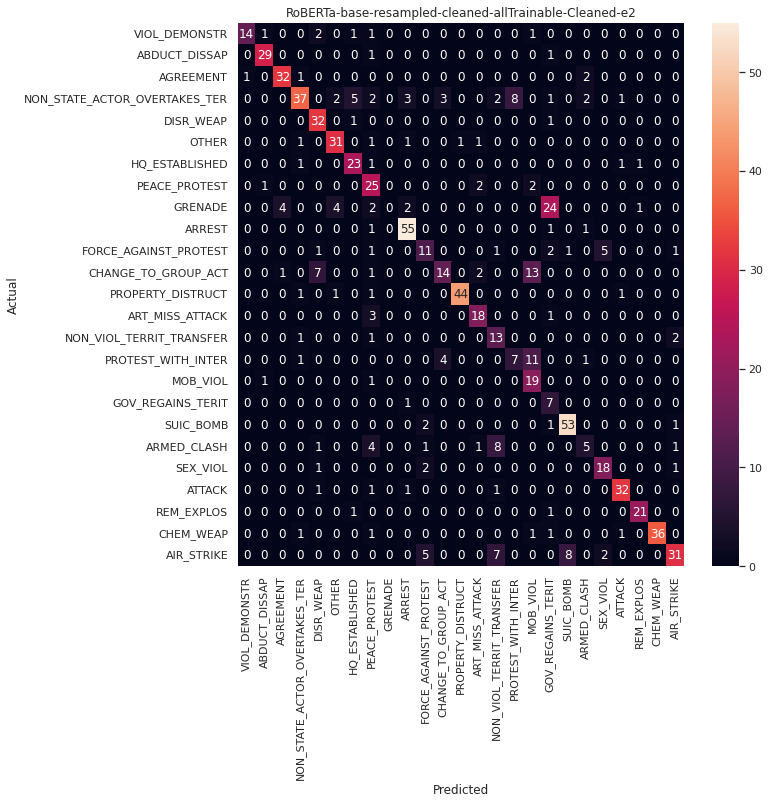

In [65]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(list(test_file.SubType), list(test_file['text-labels-cleaned']))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=set(test_file.SubType), yticklabels=set(test_file.SubType))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('RoBERTa-base-resampled-cleaned-allTrainable-Cleaned-e2')
plt.show()

## For lemmatized Text

In [66]:
final_test_inputs, final_test_attention_masks = roberta_encode(list(test_file.lemmatized), max_length)

  0%|          | 0/829 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 829/829 [00:00<00:00, 2242.76it/s]


In [67]:
y_preds = np.argmax(model.predict([final_test_inputs, final_test_attention_masks]), axis=1)

In [68]:
y_preds

array([ 4,  8, 12, 23, 10, 16,  1, 19, 19, 18, 21, 10,  1, 14, 20,  2, 18,
        8,  6,  3,  5,  0, 20,  3, 14,  6,  7, 10,  6, 18,  5,  0, 20, 14,
       23, 20, 14, 22, 23, 16, 11, 11, 22, 18, 18,  5, 19,  8, 17, 10, 16,
        3, 15, 11, 19, 16, 19, 17,  0, 18, 14, 10, 13,  5, 10,  2,  5, 18,
       10, 17,  7,  1,  4, 20, 17, 19, 15,  1,  2, 21, 20, 20,  1,  3, 14,
        2,  2,  7, 10, 18,  3, 13, 18,  0,  6, 18,  2,  1,  1, 12,  8, 20,
       23,  0, 14, 16,  1,  3,  7,  2, 16,  9, 10, 12, 12,  4, 20, 13,  8,
       23, 16,  6, 10,  8,  6,  0, 13, 14,  1,  0, 21,  0, 13, 14, 10,  5,
       11, 16, 11, 21,  1,  6,  6,  0,  4,  0, 18,  1,  3, 23,  5, 13, 23,
       23,  7, 14, 21, 13, 16, 16, 18, 14,  3, 18,  3,  0, 11, 19,  4, 18,
       11, 18,  5, 19, 21,  7,  1, 16, 23, 11, 18, 14, 11, 11,  1, 20, 22,
        5, 16, 20, 10,  0, 22, 19, 16, 22,  8, 20, 14,  3, 18, 22, 22, 11,
        2, 11, 17, 10, 15,  4, 19,  6,  2,  4,  5, 16,  7, 16, 17,  3,  1,
        1,  1, 14,  6, 22

In [69]:
test_file['pred-labels-lemmatized'] = y_preds

In [70]:
test_file.head()

,EventSnippet,SubType,processed,lemmatized,pred-labels-cleaned,text-labels-cleaned,pred-labels-lemmatized
id,,,,,,,
1,The US warplanes pounded the village of Kashka...,AIR_STRIKE,the us warplanes pounded the village of kashka...,u warplane pounded village kashkash southern p...,4,AIR_STRIKE,4
3,Officers brutally attacked and injured a peace...,FORCE_AGAINST_PROTEST,officers brutally attacked and injured a peace...,officer brutally attacked injured peaceful stu...,8,FORCE_AGAINST_PROTEST,8
4,"On December 13, ISIS fighters recaptured the v...",NON_STATE_ACTOR_OVERTAKES_TER,isis fighters recaptured the village of kashma...,isi fighter recaptured village kashma syrian a...,12,GOV_REGAINS_TERIT,12
5,Vice-President Mike Pence said Thursday that t...,AGREEMENT,vice-president mike pence said thursday that t...,vice-president mike penny said thursday mainly...,23,AGREEMENT,23
6,A helicopter on Thursday is said to have dropp...,CHEM_WEAP,a helicopter thursday is said to have dropped ...,helicopter thursday said dropped container tox...,10,OTHER,10


In [71]:
def num_to_text_labels(num):
    text = event_types_dict_inverse[num]
    return text

test_file['text-labels-lemmatized'] = test_file['pred-labels-lemmatized'].apply(num_to_text_labels)

In [72]:
test_file.head()

,EventSnippet,SubType,processed,lemmatized,pred-labels-cleaned,text-labels-cleaned,pred-labels-lemmatized,text-labels-lemmatized
id,,,,,,,,
1,The US warplanes pounded the village of Kashka...,AIR_STRIKE,the us warplanes pounded the village of kashka...,u warplane pounded village kashkash southern p...,4,AIR_STRIKE,4,AIR_STRIKE
3,Officers brutally attacked and injured a peace...,FORCE_AGAINST_PROTEST,officers brutally attacked and injured a peace...,officer brutally attacked injured peaceful stu...,8,FORCE_AGAINST_PROTEST,8,FORCE_AGAINST_PROTEST
4,"On December 13, ISIS fighters recaptured the v...",NON_STATE_ACTOR_OVERTAKES_TER,isis fighters recaptured the village of kashma...,isi fighter recaptured village kashma syrian a...,12,GOV_REGAINS_TERIT,12,GOV_REGAINS_TERIT
5,Vice-President Mike Pence said Thursday that t...,AGREEMENT,vice-president mike pence said thursday that t...,vice-president mike penny said thursday mainly...,23,AGREEMENT,23,AGREEMENT
6,A helicopter on Thursday is said to have dropp...,CHEM_WEAP,a helicopter thursday is said to have dropped ...,helicopter thursday said dropped container tox...,10,OTHER,10,OTHER


In [73]:
test_file.to_csv('results-roberta-Untrained-base-resampled-cleaned-epoch-2.csv', index=True)

In [74]:

from sklearn.metrics import classification_report

print(classification_report(y_true= list(test_file.SubType), y_pred= list(test_file['text-labels-lemmatized'])))

                               precision    recall  f1-score   support

                ABDUCT_DISSAP       0.93      0.65      0.76        20
                    AGREEMENT       0.94      0.94      0.94        31
                   AIR_STRIKE       0.81      0.72      0.76        36
                  ARMED_CLASH       0.89      0.61      0.72        66
                       ARREST       0.55      0.91      0.69        34
              ART_MISS_ATTACK       0.69      0.86      0.77        36
                       ATTACK       0.57      0.85      0.69        27
          CHANGE_TO_GROUP_ACT       0.51      0.80      0.62        30
                    CHEM_WEAP       0.00      0.00      0.00        37
                    DISR_WEAP       0.93      0.88      0.90        58
        FORCE_AGAINST_PROTEST       0.50      0.52      0.51        23
            GOV_REGAINS_TERIT       0.62      0.26      0.37        38
                      GRENADE       1.00      0.81      0.90        48
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


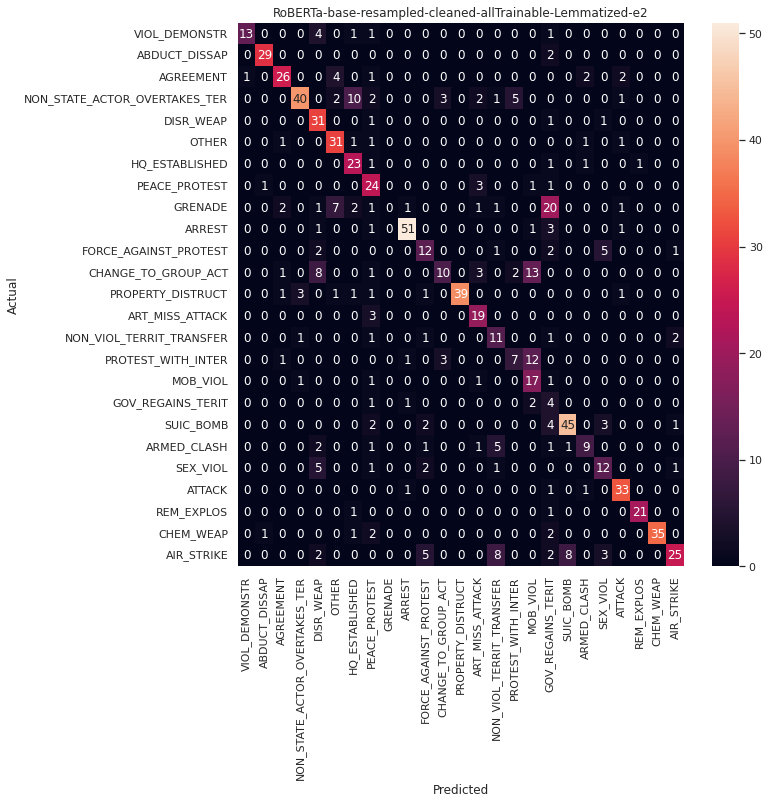

In [75]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix( list(test_file.SubType), list(test_file['text-labels-lemmatized']))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=set(test_file.SubType), yticklabels=set(test_file.SubType))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('RoBERTa-base-resampled-cleaned-allTrainable-Lemmatized-e2')
plt.show()

# Epoch - 1

In [76]:
model.load_weights('/content/saved-model-01.h5')

In [77]:
test_file = pd.read_csv('/content/drive/MyDrive/Shared Task 2021/test-set-with-labels-cleaned.txt', index_col=0)

In [78]:
test_file.head()

,EventSnippet,SubType,processed,lemmatized
id,,,,
1,The US warplanes pounded the village of Kashka...,AIR_STRIKE,the us warplanes pounded the village of kashka...,u warplane pounded village kashkash southern p...
3,Officers brutally attacked and injured a peace...,FORCE_AGAINST_PROTEST,officers brutally attacked and injured a peace...,officer brutally attacked injured peaceful stu...
4,"On December 13, ISIS fighters recaptured the v...",NON_STATE_ACTOR_OVERTAKES_TER,isis fighters recaptured the village of kashma...,isi fighter recaptured village kashma syrian a...
5,Vice-President Mike Pence said Thursday that t...,AGREEMENT,vice-president mike pence said thursday that t...,vice-president mike penny said thursday mainly...
6,A helicopter on Thursday is said to have dropp...,CHEM_WEAP,a helicopter thursday is said to have dropped ...,helicopter thursday said dropped container tox...


## For Cleaned Text

In [79]:
final_test_inputs, final_test_attention_masks = roberta_encode(list(test_file.processed), max_length)

  0%|          | 0/829 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 829/829 [00:00<00:00, 1940.51it/s]


In [80]:
y_preds = np.argmax(model.predict([final_test_inputs, final_test_attention_masks]), axis=1)

In [81]:
y_preds

array([ 4,  8, 15, 23, 24, 10,  1, 12, 12, 18, 10, 10,  1, 14, 20,  7, 18,
        8,  6,  3,  5,  0, 20,  3, 10,  6,  7, 18,  6, 18,  5,  0, 20, 14,
       23, 20, 14, 22, 23, 16, 11, 18, 22, 18, 18,  5, 19,  8, 17, 10, 12,
       24, 15, 11, 19, 16, 12, 17,  0, 18, 16, 24, 13,  5,  9,  2,  5, 18,
        8, 17,  7,  1, 10, 20, 17, 12, 15,  7,  7, 21, 20, 20,  1,  3,  5,
        6,  2,  7,  8, 18,  3, 13, 10, 10,  8, 18,  2,  8,  1, 12,  8, 20,
       23,  0,  7, 18,  1,  3,  7,  8, 16,  5, 24, 12, 12,  4, 20, 13,  8,
       23,  6,  6, 18,  8,  6,  0, 13, 14,  1, 18, 21,  0, 13, 19, 23,  5,
        5, 16, 11, 14,  1,  6,  6,  0,  4,  0,  9,  1, 11, 23,  5, 13, 23,
       23, 16, 14, 21, 13, 12, 12, 18, 14,  3, 18,  3,  0, 11, 19,  4, 18,
       11, 18,  5, 19, 21,  1,  7, 12, 23, 11, 18,  3, 11, 11,  1, 20, 22,
        5, 16, 20, 10, 13, 22, 19,  2, 22,  8, 20, 14,  3, 18, 22, 22, 11,
        8, 11, 17,  0, 15, 20,  5,  7,  2, 12, 15, 16,  7,  7, 17,  3,  1,
        1,  1,  5,  5,  5

In [82]:
test_file['pred-labels-cleaned'] = y_preds

In [83]:
test_file.head()

,EventSnippet,SubType,processed,lemmatized,pred-labels-cleaned
id,,,,,
1,The US warplanes pounded the village of Kashka...,AIR_STRIKE,the us warplanes pounded the village of kashka...,u warplane pounded village kashkash southern p...,4
3,Officers brutally attacked and injured a peace...,FORCE_AGAINST_PROTEST,officers brutally attacked and injured a peace...,officer brutally attacked injured peaceful stu...,8
4,"On December 13, ISIS fighters recaptured the v...",NON_STATE_ACTOR_OVERTAKES_TER,isis fighters recaptured the village of kashma...,isi fighter recaptured village kashma syrian a...,15
5,Vice-President Mike Pence said Thursday that t...,AGREEMENT,vice-president mike pence said thursday that t...,vice-president mike penny said thursday mainly...,23
6,A helicopter on Thursday is said to have dropp...,CHEM_WEAP,a helicopter thursday is said to have dropped ...,helicopter thursday said dropped container tox...,24


In [84]:
def num_to_text_labels(num):
    text = event_types_dict_inverse[num]
    return text

test_file['text-labels-cleaned'] = test_file['pred-labels-cleaned'].apply(num_to_text_labels)

In [85]:
test_file.head()

,EventSnippet,SubType,processed,lemmatized,pred-labels-cleaned,text-labels-cleaned
id,,,,,,
1,The US warplanes pounded the village of Kashka...,AIR_STRIKE,the us warplanes pounded the village of kashka...,u warplane pounded village kashkash southern p...,4,AIR_STRIKE
3,Officers brutally attacked and injured a peace...,FORCE_AGAINST_PROTEST,officers brutally attacked and injured a peace...,officer brutally attacked injured peaceful stu...,8,FORCE_AGAINST_PROTEST
4,"On December 13, ISIS fighters recaptured the v...",NON_STATE_ACTOR_OVERTAKES_TER,isis fighters recaptured the village of kashma...,isi fighter recaptured village kashma syrian a...,15,NON_STATE_ACTOR_OVERTAKES_TER
5,Vice-President Mike Pence said Thursday that t...,AGREEMENT,vice-president mike pence said thursday that t...,vice-president mike penny said thursday mainly...,23,AGREEMENT
6,A helicopter on Thursday is said to have dropp...,CHEM_WEAP,a helicopter thursday is said to have dropped ...,helicopter thursday said dropped container tox...,24,CHEM_WEAP


### **classification_report**

In [86]:

from sklearn.metrics import classification_report

print(classification_report(y_true= list(test_file.SubType), y_pred= list(test_file['text-labels-cleaned'])))

                               precision    recall  f1-score   support

                ABDUCT_DISSAP       0.76      0.80      0.78        20
                    AGREEMENT       0.94      0.94      0.94        31
                   AIR_STRIKE       0.96      0.75      0.84        36
                  ARMED_CLASH       0.86      0.73      0.79        66
                       ARREST       0.96      0.76      0.85        34
              ART_MISS_ATTACK       0.74      0.81      0.77        36
                       ATTACK       0.74      0.96      0.84        27
          CHANGE_TO_GROUP_ACT       0.89      0.80      0.84        30
                    CHEM_WEAP       0.94      0.41      0.57        37
                    DISR_WEAP       0.85      0.98      0.91        58
        FORCE_AGAINST_PROTEST       0.39      0.65      0.49        23
            GOV_REGAINS_TERIT       0.79      0.71      0.75        38
                      GRENADE       0.98      0.90      0.93        48
     

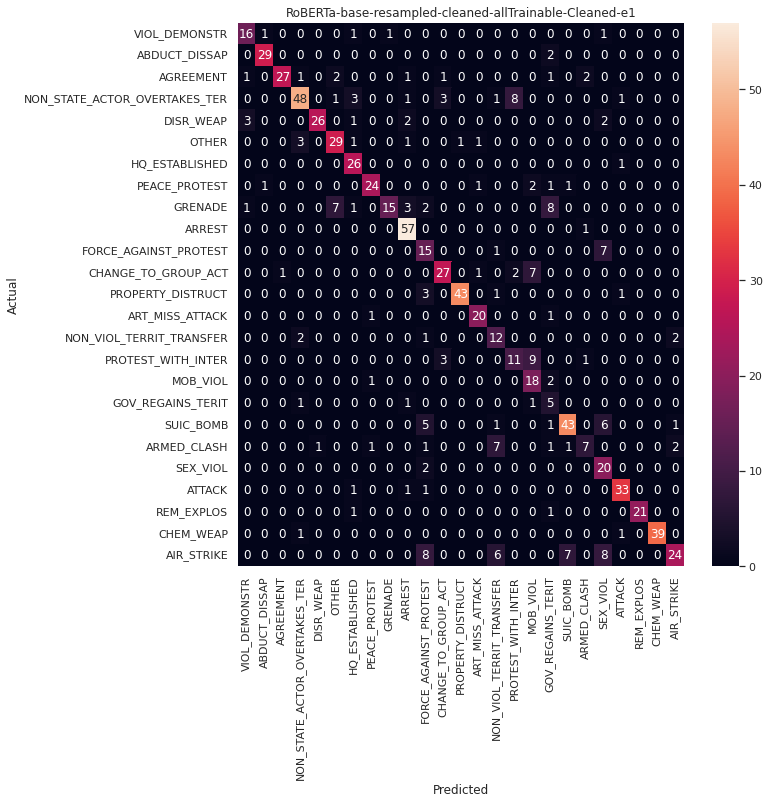

In [87]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(list(test_file.SubType), list(test_file['text-labels-cleaned']))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=set(test_file.SubType), yticklabels=set(test_file.SubType))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('RoBERTa-base-resampled-cleaned-allTrainable-Cleaned-e1')
plt.show()

## For lemmatized Text

In [88]:
final_test_inputs, final_test_attention_masks = roberta_encode(list(test_file.lemmatized), max_length)

  0%|          | 0/829 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 829/829 [00:00<00:00, 2181.22it/s]


In [89]:
y_preds = np.argmax(model.predict([final_test_inputs, final_test_attention_masks]), axis=1)

In [90]:
y_preds

array([ 4,  8, 12, 23, 10, 10,  1, 12, 12, 18, 21,  3,  1, 14, 20,  2, 18,
        8,  6,  3,  5,  0, 20,  3, 10,  6,  7, 18,  6, 18,  5,  0, 20, 14,
       23, 20, 10, 22, 23, 16, 11, 18, 22, 10, 18,  5, 19,  8, 17, 10, 12,
        3,  5, 11, 19, 16, 12, 17, 24, 18, 10,  3, 13,  5,  6,  8,  5, 18,
        8, 17,  7,  1, 10, 20, 17, 12, 15,  1,  8, 21, 20, 20,  1,  3,  5,
        6,  2,  7,  3, 18,  3, 13, 18,  0,  8, 18,  2,  7,  1, 12,  8, 20,
       23,  0,  6,  3,  1,  3,  7,  8, 16,  5,  3, 12,  5,  4, 20, 13,  8,
       23,  6,  6, 11,  8,  6,  0, 13, 14,  1,  5, 21,  0, 13, 19, 23,  5,
        5, 16, 11, 21,  1,  6,  6, 18,  4,  0,  9,  1,  3, 23,  5, 13, 23,
       23,  7, 14, 21, 13, 12, 12, 18, 14,  3, 18,  3,  0, 11, 19,  4, 18,
       11, 18,  5, 15, 21,  1,  7, 16, 23, 11, 18,  3, 11, 11,  1, 20, 22,
        5, 16, 20, 23, 24, 22, 15, 16, 22,  8, 20, 14,  5, 18, 22, 22, 11,
        8, 11, 17,  3, 15, 20, 16,  7,  1, 12,  5, 16,  7,  8, 17,  5,  1,
        1,  1,  5,  5, 22

In [91]:
test_file['pred-labels-lemmatized'] = y_preds

In [92]:
test_file.head()

,EventSnippet,SubType,processed,lemmatized,pred-labels-cleaned,text-labels-cleaned,pred-labels-lemmatized
id,,,,,,,
1,The US warplanes pounded the village of Kashka...,AIR_STRIKE,the us warplanes pounded the village of kashka...,u warplane pounded village kashkash southern p...,4,AIR_STRIKE,4
3,Officers brutally attacked and injured a peace...,FORCE_AGAINST_PROTEST,officers brutally attacked and injured a peace...,officer brutally attacked injured peaceful stu...,8,FORCE_AGAINST_PROTEST,8
4,"On December 13, ISIS fighters recaptured the v...",NON_STATE_ACTOR_OVERTAKES_TER,isis fighters recaptured the village of kashma...,isi fighter recaptured village kashma syrian a...,15,NON_STATE_ACTOR_OVERTAKES_TER,12
5,Vice-President Mike Pence said Thursday that t...,AGREEMENT,vice-president mike pence said thursday that t...,vice-president mike penny said thursday mainly...,23,AGREEMENT,23
6,A helicopter on Thursday is said to have dropp...,CHEM_WEAP,a helicopter thursday is said to have dropped ...,helicopter thursday said dropped container tox...,24,CHEM_WEAP,10


In [93]:
def num_to_text_labels(num):
    text = event_types_dict_inverse[num]
    return text

test_file['text-labels-lemmatized'] = test_file['pred-labels-lemmatized'].apply(num_to_text_labels)

In [94]:
test_file.head()

,EventSnippet,SubType,processed,lemmatized,pred-labels-cleaned,text-labels-cleaned,pred-labels-lemmatized,text-labels-lemmatized
id,,,,,,,,
1,The US warplanes pounded the village of Kashka...,AIR_STRIKE,the us warplanes pounded the village of kashka...,u warplane pounded village kashkash southern p...,4,AIR_STRIKE,4,AIR_STRIKE
3,Officers brutally attacked and injured a peace...,FORCE_AGAINST_PROTEST,officers brutally attacked and injured a peace...,officer brutally attacked injured peaceful stu...,8,FORCE_AGAINST_PROTEST,8,FORCE_AGAINST_PROTEST
4,"On December 13, ISIS fighters recaptured the v...",NON_STATE_ACTOR_OVERTAKES_TER,isis fighters recaptured the village of kashma...,isi fighter recaptured village kashma syrian a...,15,NON_STATE_ACTOR_OVERTAKES_TER,12,GOV_REGAINS_TERIT
5,Vice-President Mike Pence said Thursday that t...,AGREEMENT,vice-president mike pence said thursday that t...,vice-president mike penny said thursday mainly...,23,AGREEMENT,23,AGREEMENT
6,A helicopter on Thursday is said to have dropp...,CHEM_WEAP,a helicopter thursday is said to have dropped ...,helicopter thursday said dropped container tox...,24,CHEM_WEAP,10,OTHER


In [95]:
test_file.to_csv('results-roberta-Untrained-base-resampled-cleaned-epoch-1.csv', index=True)

### **classification_report**

In [96]:

from sklearn.metrics import classification_report

print(classification_report(y_true= list(test_file.SubType), y_pred= list(test_file['text-labels-lemmatized'])))

                               precision    recall  f1-score   support

                ABDUCT_DISSAP       0.76      0.80      0.78        20
                    AGREEMENT       0.93      0.90      0.92        31
                   AIR_STRIKE       0.90      0.75      0.82        36
                  ARMED_CLASH       0.81      0.82      0.81        66
                       ARREST       0.85      0.68      0.75        34
              ART_MISS_ATTACK       0.73      0.75      0.74        36
                       ATTACK       0.50      0.93      0.65        27
          CHANGE_TO_GROUP_ACT       0.78      0.70      0.74        30
                    CHEM_WEAP       1.00      0.38      0.55        37
                    DISR_WEAP       0.87      0.93      0.90        58
        FORCE_AGAINST_PROTEST       0.37      0.70      0.48        23
            GOV_REGAINS_TERIT       0.85      0.74      0.79        38
                      GRENADE       0.93      0.90      0.91        48
     

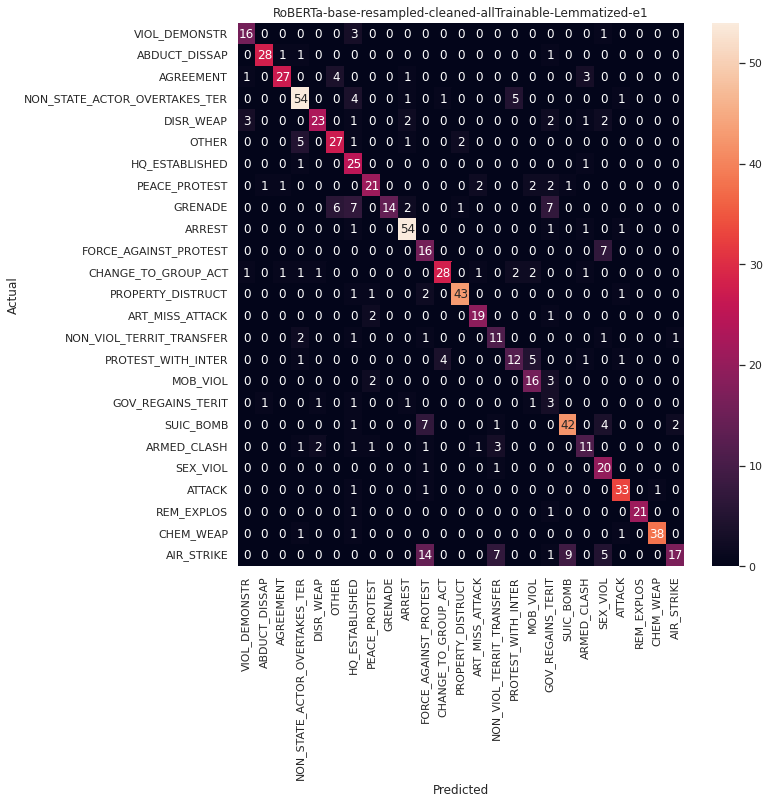

In [97]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix( list(test_file.SubType), list(test_file['text-labels-lemmatized']))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=set(test_file.SubType), yticklabels=set(test_file.SubType))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('RoBERTa-base-resampled-cleaned-allTrainable-Lemmatized-e1')
plt.show()